/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  m = torch.stack(


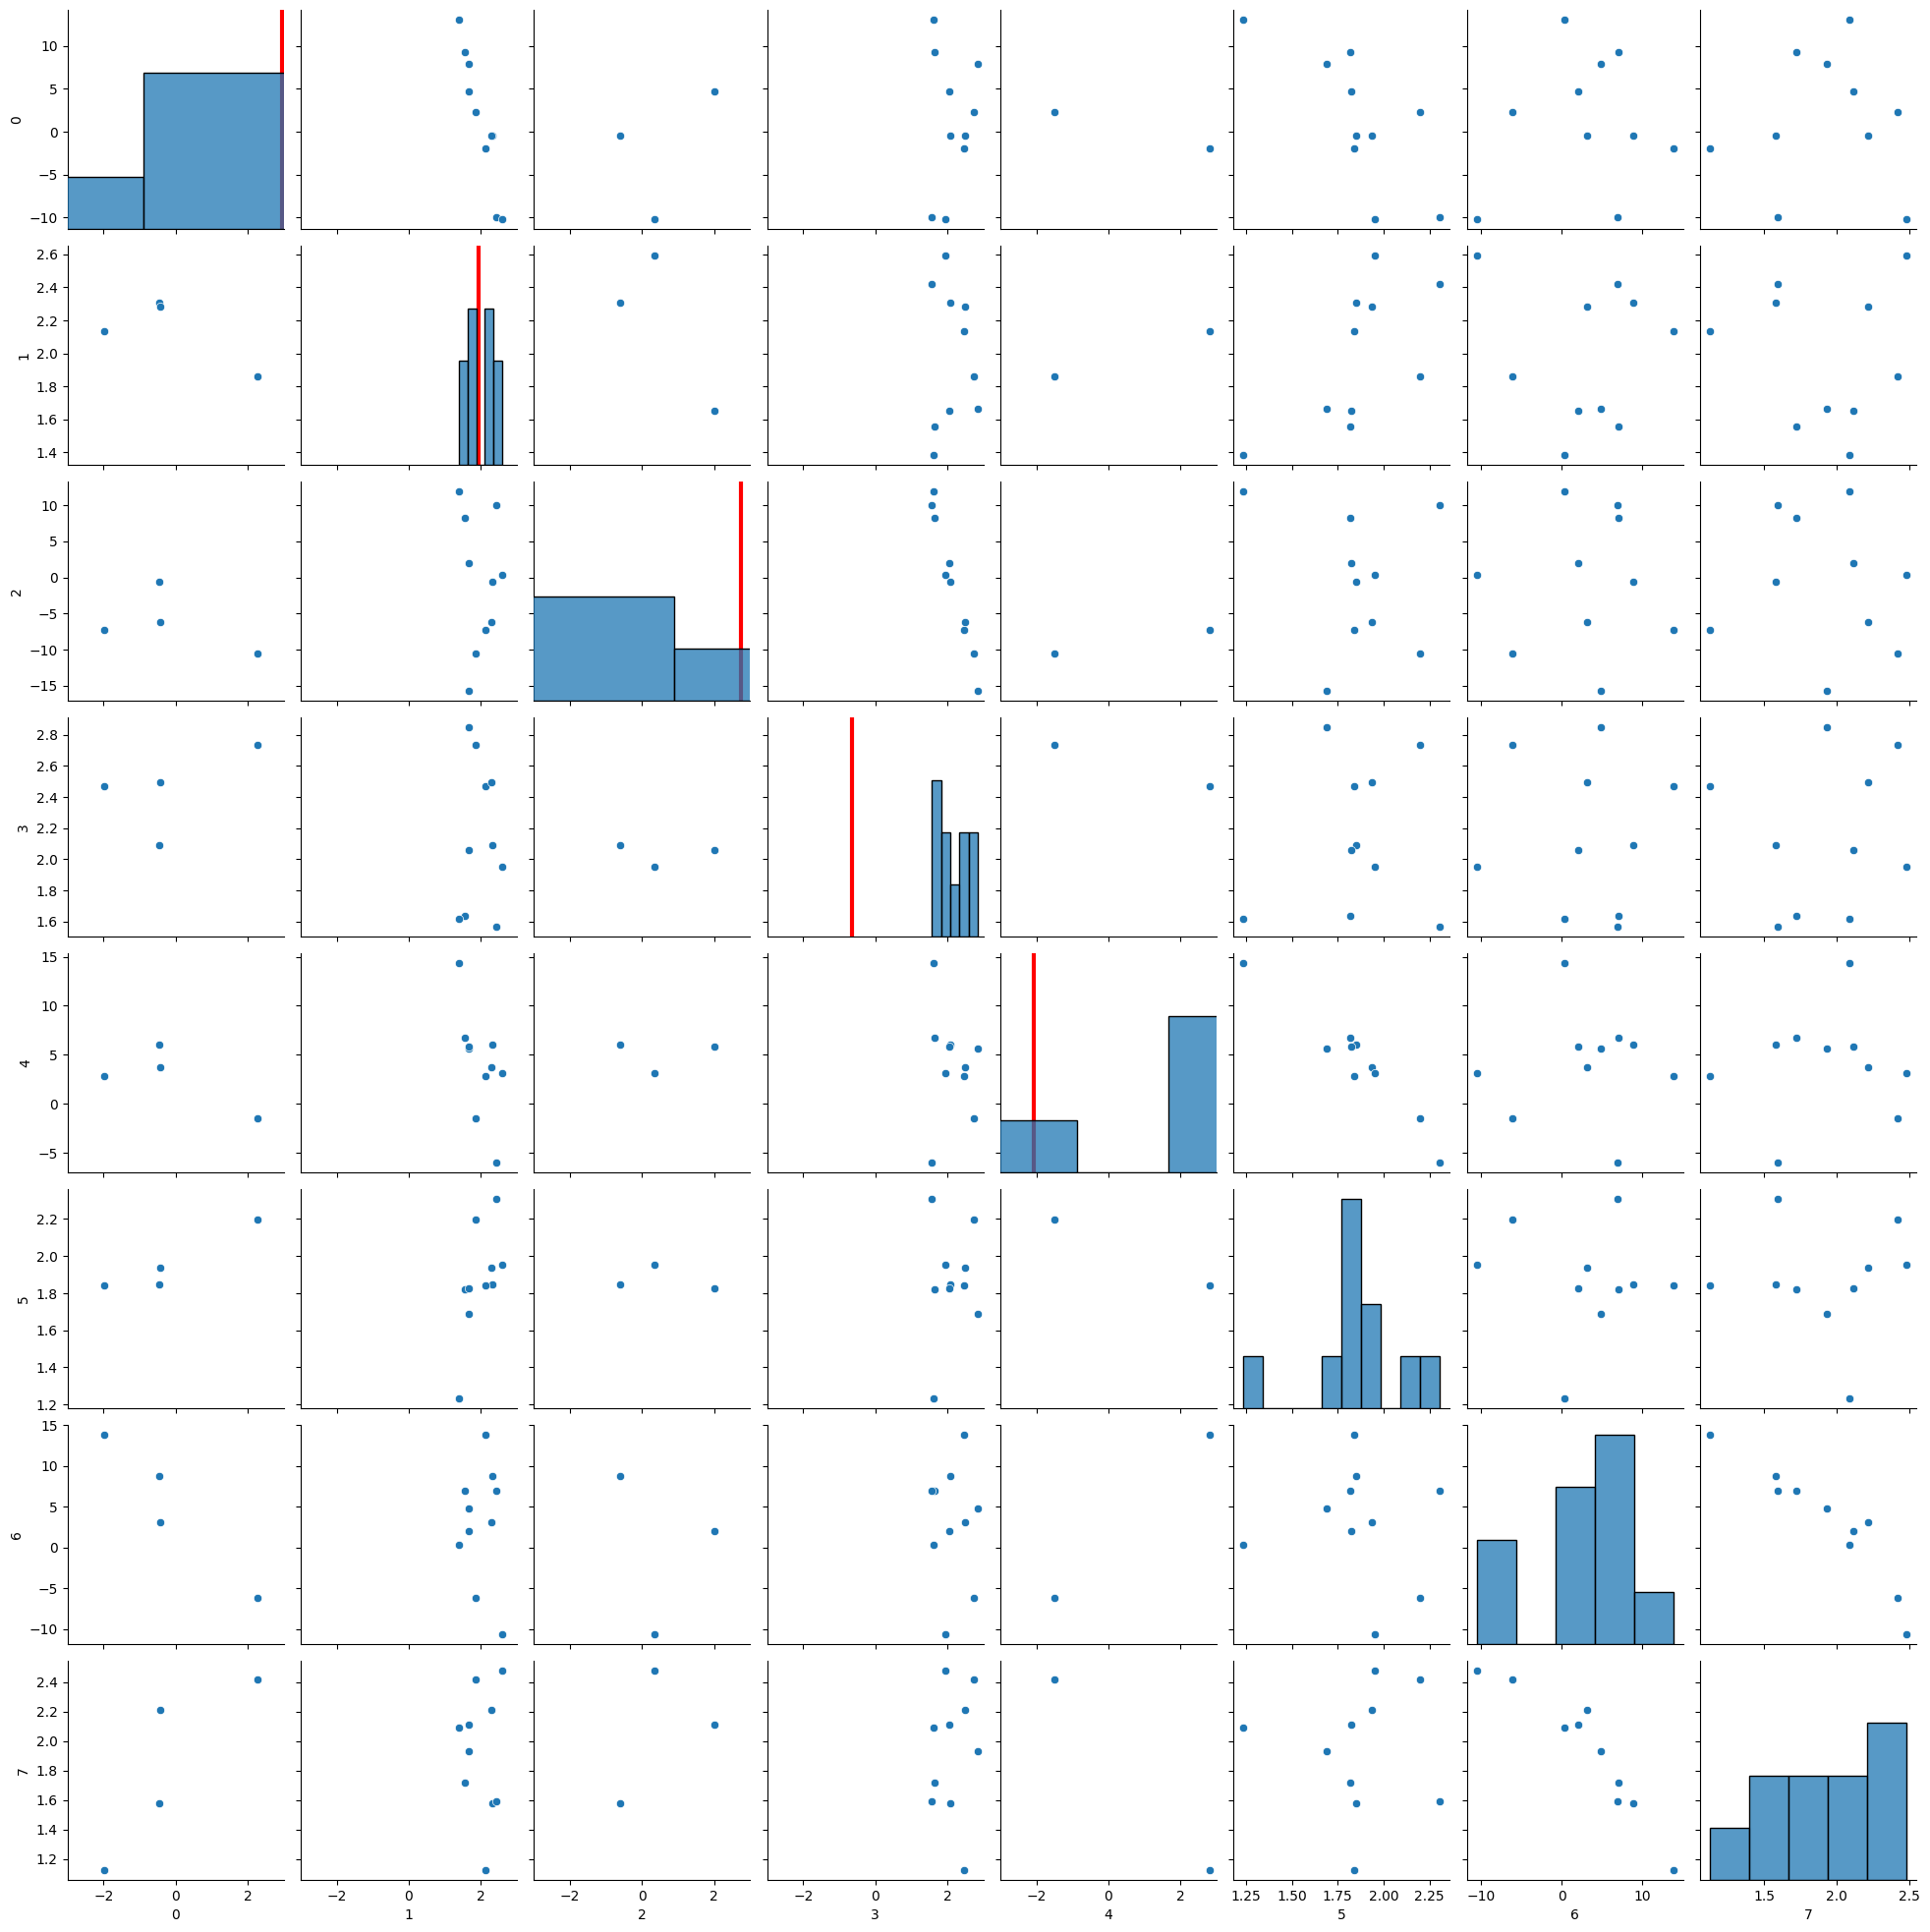

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot

import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import SLCP, SLCP_wrapper
import sbibm
from seaborn import pairplot
import warnings
warnings.simplefilter('ignore', FutureWarning)


prior = sbibm.get_task('slcp').get_prior_dist()
t = prior.sample((1,))[0]

X = SLCP_wrapper(reps=10, parameters=t)
# g = pairplot(pd.DataFrame(X.numpy()))
# for i in range(len(t)):
#     g.axes[i,i].axvline(t[i],color='red', linewidth=3)
#     g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

In [14]:
from simulators import WF
from sbi.utils import BoxUniform
import torch
import pickle
import time
from sbi.inference import NPSE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

prior = BoxUniform(low=torch.tensor([-2, -7, -8]), high=torch.tensor([0, -2, -2]))

# time
start = time.time()

# Define the prior and simulator
sim = 'WF'
simulator = WF

# inference
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Inference
inference = NPSE(prior, sde_type='ve')

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train(training_batch_size=200, stop_after_epochs=2)
posterior = inference.build_posterior(density_estimator)

# time
end = time.time()
print(f'Inference time: {end - start} seconds')

posterior.set_default_x(X).sample((100,)).mean(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 35 epochs.Inference time: 117.93358206748962 seconds


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 100 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

NotImplementedError: Score accumulation for IID data is not yet implemented.

In [16]:
posterior.set_default_x(X[0,:]).sample((100,)).mean(0)

Drawing 100 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

tensor([-1.0186, -4.1275, -5.2765])

In [16]:
posterior_cp = pickle.load(open('posteriors/posterior_SLCP_10000_20.pkl', 'rb'))
epsilon = -15 # choice is detailed later
op = CollectivePosterior(prior, posterior_cp, X, 1, epsilon)
print(op.get_log_C())

tensor(-31.6809)


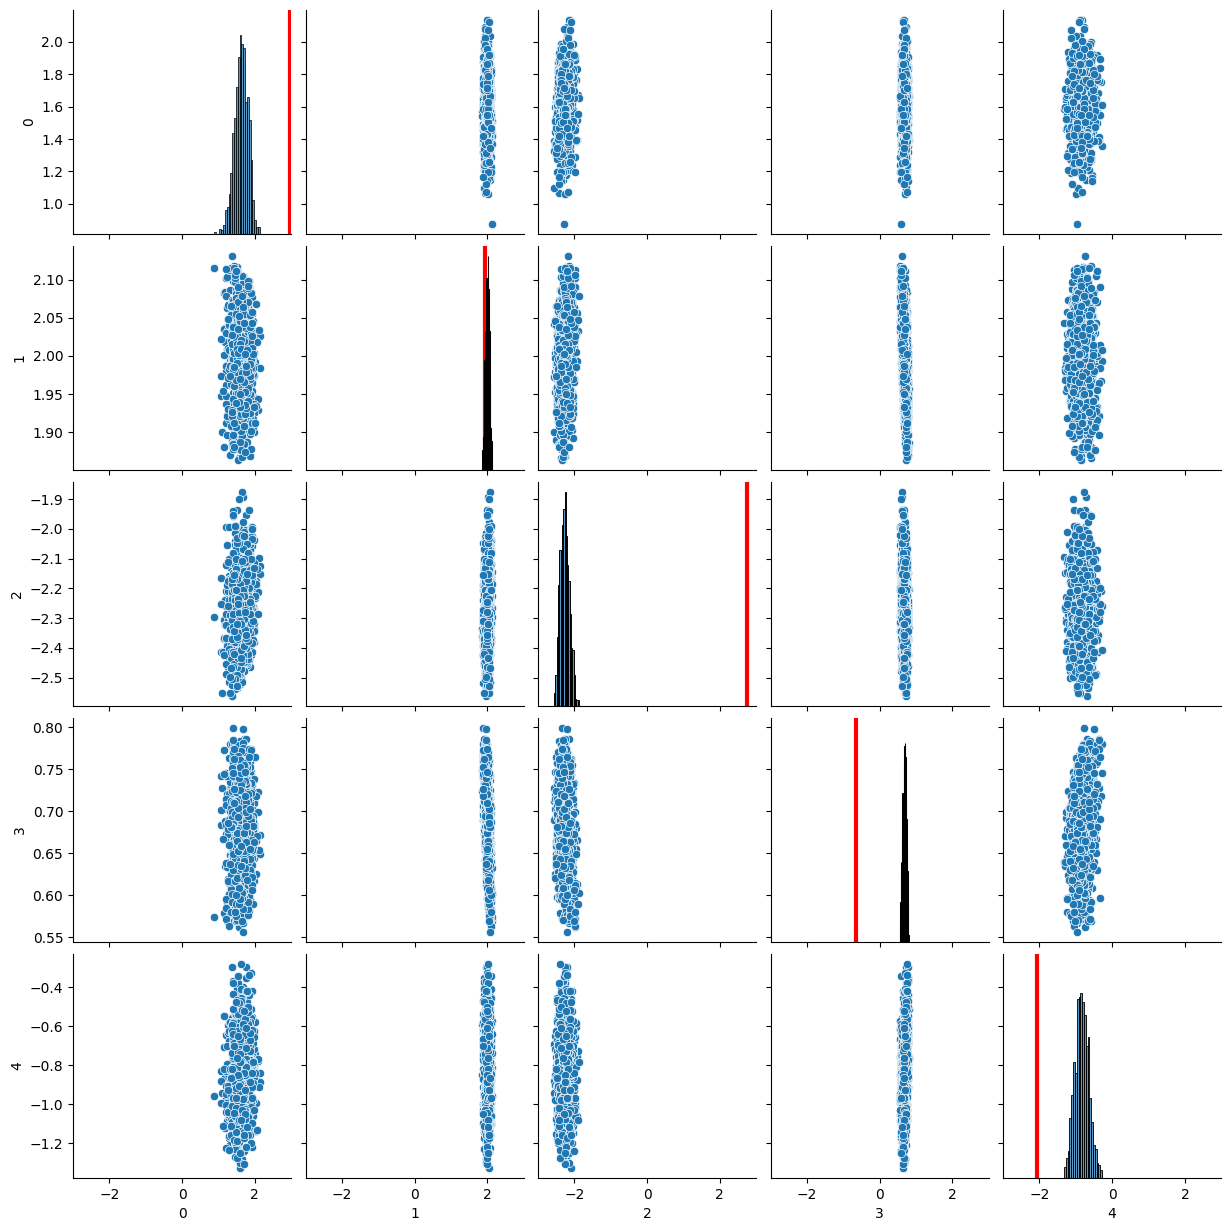

In [17]:
g = pairplot(pd.DataFrame(op.sample(1000).numpy()))
for i in range(len(t)):
    g.axes[i,i].axvline(t[i],color='red', linewidth=3)
    g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

In [18]:
res_cp = []

def eval_cp(theta):
    Xs = SLCP_wrapper(reps=10, parameters=theta)
    op = CollectivePosterior(prior, posterior_cp, Xs, 1, epsilon=-10000)
    op.get_log_C()
    m = op.sample(200).mean(0)
    r = m - theta
    return r
            
thetas = prior.sample((100,))
for i in range(len(thetas)):
    res_cp.append(eval_cp(thetas[i]))
    print(i)

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/SLCP/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


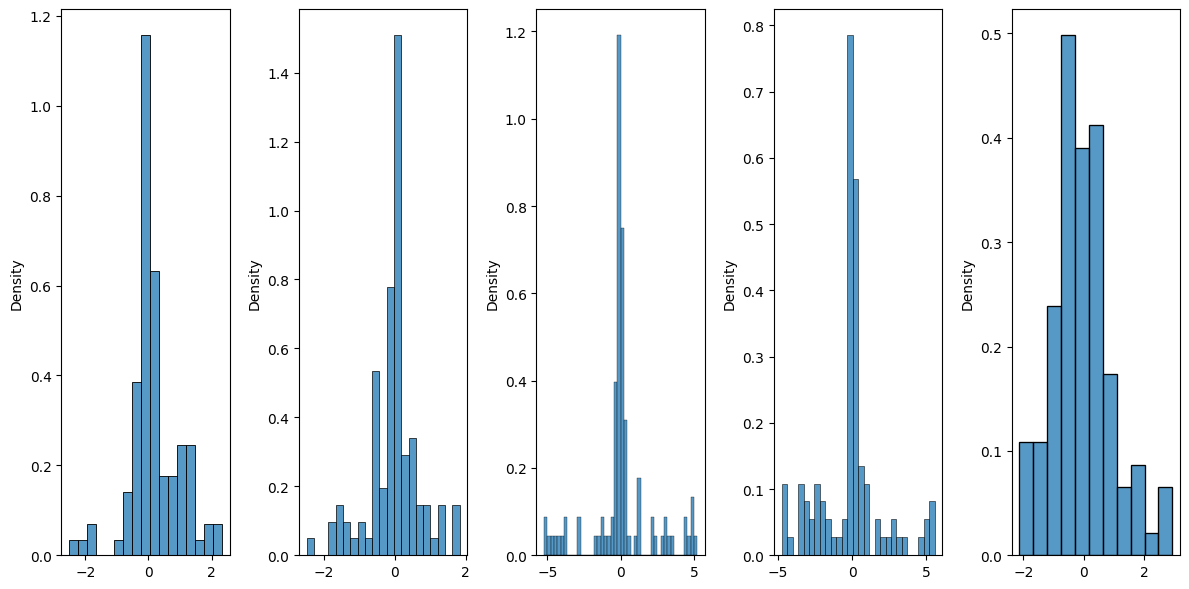

In [19]:
fig, ax = plt.subplots(1,5, figsize=(12,6), tight_layout = True)
res_cp = np.array([k.numpy() for k in res_cp])

for i in range(5):
    histplot(res_cp[:,i],ax=ax[i], stat='density')

In [20]:
sbi_posterior = pickle.load(open(f'posteriors/posterior_iid_SLCP_10000_20.pkl', 'rb'))
res_iid = torch.zeros_like(thetas)
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = SLCP_wrapper(10, theta)
    m = sbi_posterior.set_default_x(Xs).sample((200,)).mean(0)
    res_iid[i] = m - theta
    print(i)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


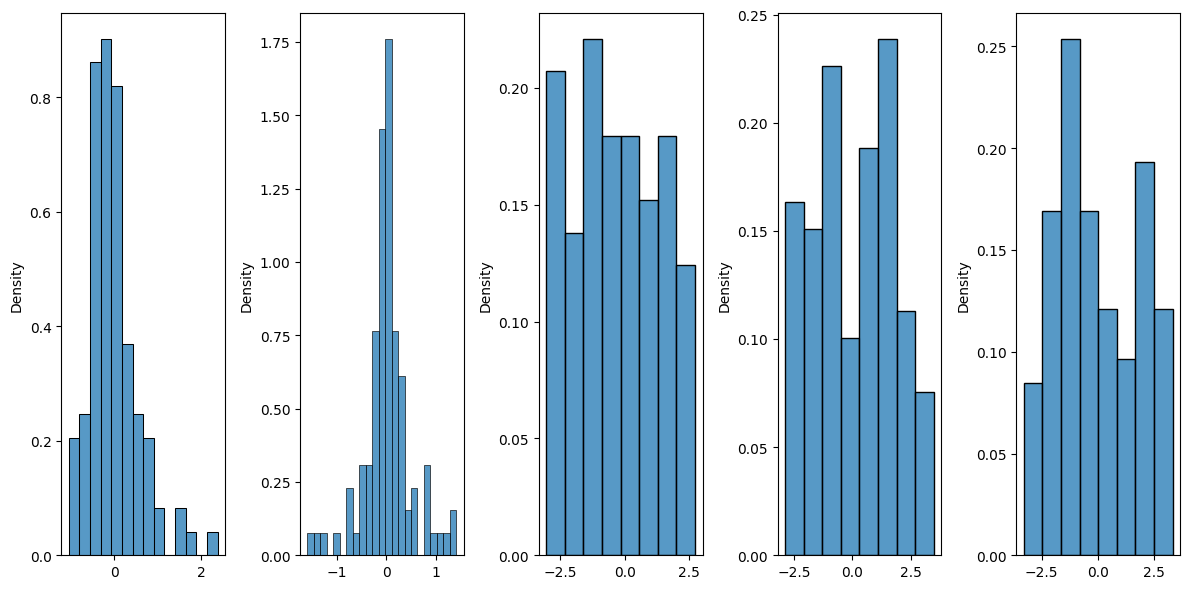

In [21]:
fig, ax = plt.subplots(1,5, figsize=(12,6), tight_layout = True)

for i in range(5):
    histplot(res_iid[:,i],ax=ax[i], stat='density')

/tmp/ipykernel_4017751/1100359219.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta = torch.tensor(thetas.iloc[i,:], dtype=torch.float32)


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

99


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

100


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

101


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

102


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

103


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

104


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

105


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

106


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

107


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

108


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

109


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

110


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

111


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

112


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

113


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

114


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

115


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

116


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

117


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

118


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

119


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

120


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

121


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

122


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

123


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

124


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

125


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

126


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

127


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

128


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

129


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

130


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

131


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

132


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

133


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

134


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

135


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

136


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

137


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

138


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

139


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

140


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

141


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

142


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

143


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

144


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

145


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

146


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

147


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

148


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

149


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

150


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

151


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

152


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

153


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

154


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

155


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

156


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

157


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

158


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

159


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

160


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

161


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

162


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

163


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

164


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

165


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

166


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

167


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

168


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

169


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

170


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

171


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

172


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

173


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

174


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

175


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

176


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

177


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

178


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

179


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

180


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

181


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

182


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

183


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

184


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

185


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

186


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

187


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

188


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

189


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

190


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

191


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

192


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

193


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

194


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

195


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

196


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

197


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

198


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

199


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

200


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

201


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

202


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

203


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

204


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

205


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

206


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

207


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

208


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

209


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

210


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

211


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

212


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

213


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

214


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

215


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

216


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

217


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

218


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

219


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

220


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

221


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

222


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

223


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

224


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

225


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

226


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

227


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

228


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

229


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

230


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

231


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

232


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

233


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

234


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

235


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

236


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

237


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

238


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

239


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

240


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

241


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

242


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

243


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

244


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

245


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

246


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

247


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

248


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

249


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

250


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

251


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

252


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

253


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

254


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

255


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

256


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

257


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

258


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

259


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

260


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

261


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

262


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

263


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

264


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

265


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

266


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

267


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

268


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

269


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

270


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

271


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

272


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

273


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

274


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

275


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

276


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

277


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

278


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

279


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

280


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

281


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

282


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

283


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

284


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

285


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

286


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

287


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

288


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

289


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

290


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

291


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

292


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

293


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

294


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

295


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

296


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

297


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

298


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

299


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

300


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

301


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

302


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

303


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

304


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

305


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

306


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

307


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

308


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

309


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

310


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

311


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

312


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

313


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

314


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

315


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

316


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

317


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

318


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

319


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

320


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

321


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

322


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

323


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

324


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

325


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

326


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

327


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

328


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

329


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

330


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

331


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

332


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

333


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

334


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

335


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

336


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

337


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

338


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

339


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

340


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

341


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

342


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

343


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

344


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

345


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

346


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

347


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

348


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

349


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

350


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

351


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

352


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

353


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

354


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

355


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

356


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

357


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

358


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

359


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

360


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

361


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

362


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

363


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

364


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

365


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

366


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

367


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

368


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

369


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

370


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

371


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

372


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

373


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

374


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

375


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

376


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

377


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

378


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

379


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

380


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

381


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

382


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

383


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

384


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

385


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

386


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

387


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

388


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

389


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

390


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

391


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

392


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

393


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

394


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

395


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

396


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

397


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

398


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

399


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

400


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

401


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

402


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

403


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

404


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

405


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

406


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

407


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

408


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

409


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

410


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

411


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

412


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

413


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

414


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

415


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

416


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

417


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

418


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

419


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

420


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

421


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

422


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

423


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

424


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

425


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

426


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

427


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

428


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

429


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

430


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

431


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

432


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

433


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

434


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

435


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

436


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

437


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

438


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

439


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

440


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

441


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

442


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

443


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

444


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

445


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

446


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

447


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

448


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

449


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

450


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

451


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

452


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

453


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

454


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

455


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

456


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

457


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

458


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

459


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

460


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

461


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

462


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

463


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

464


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

465


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

466


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

467


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

468


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

469


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

470


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

471


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

472


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

473


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

474


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

475


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

476


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

477


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

478


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

479


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

480


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

481


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

482


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

483


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

484


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

485


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

486


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

487


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

488


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

489


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

490


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

491


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

492


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

493


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

494


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

495


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

496


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

497


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

498


Drawing 200 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

499


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

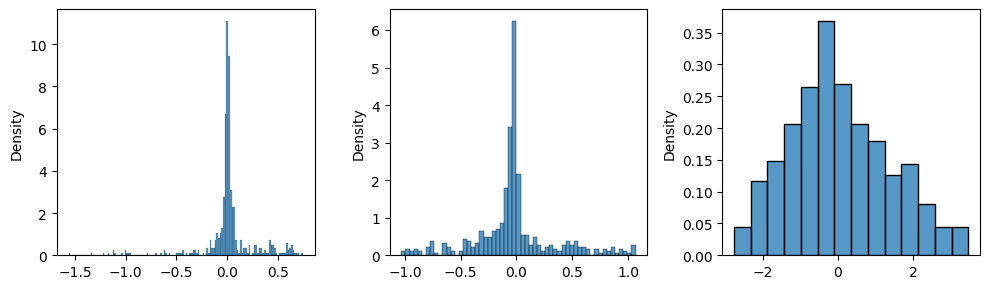

In [53]:
# eval for diffusion posterior

prior_min_t = np.log10(np.array([1e-1,1e-6,1e-6]))
prior_max_t = np.log10(np.array([0.2,1e-4,1e-4]))
test_prior = utils.BoxUniform(low=torch.tensor(prior_min_t), 
                         high=torch.tensor(prior_max_t))

thetas = pd.read_csv('tests/test_thetas.csv').iloc[:,1:]
res = np.zeros_like(thetas)

for i in range(len(thetas)):
    theta = torch.tensor(thetas.iloc[i,:], dtype=torch.float32)
    Xs = WF(np.array(theta))
    m = posterior.set_default_x(Xs).sample((200,)).mean(0)
    res[i] = m - theta
    print(i)

fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')

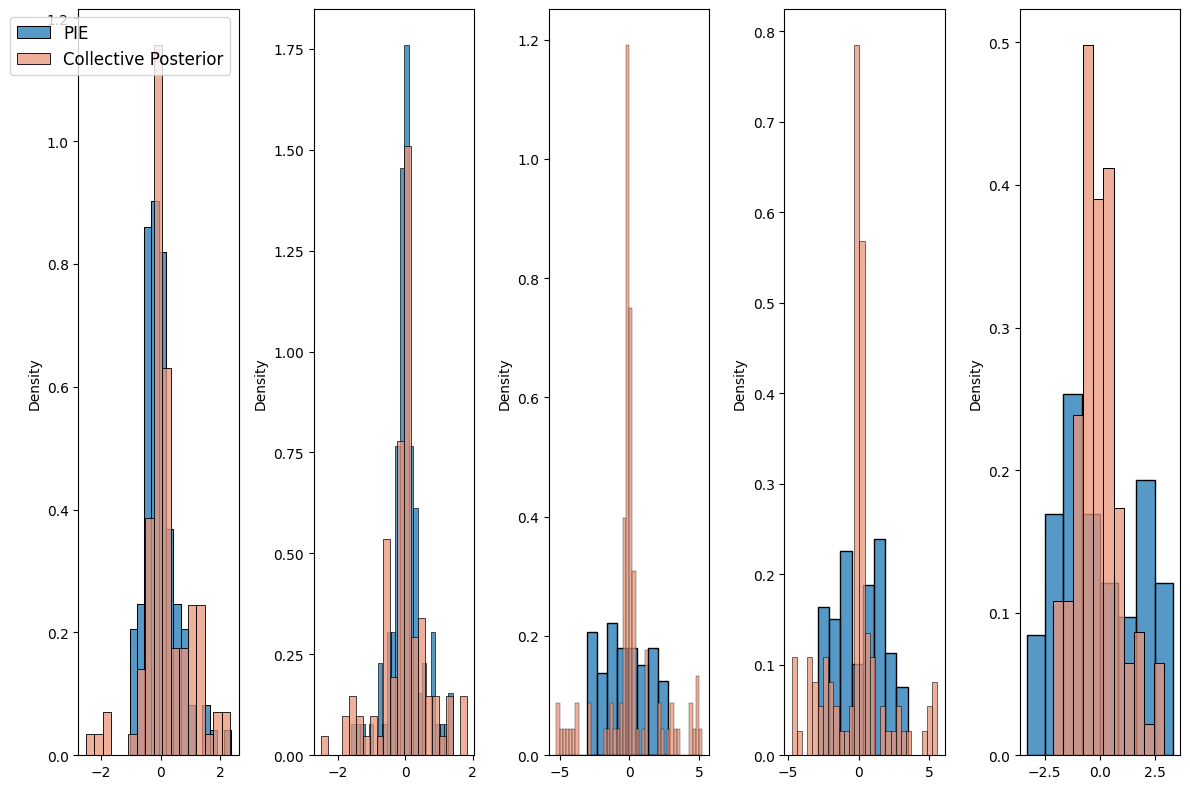

In [24]:
# Comparing methods

from seaborn import histplot
fig, ax = plt.subplots(1,5, figsize=(12,8), tight_layout = True)
# res_cp = np.array(pd.read_csv('tests/test_eval_cp_WF_10000_20.csv',index_col=0))
# res_iid = np.array(pd.read_csv('tests/test_eval_iid_WF_10000_20.csv',index_col=0))

# PIE
for i in range(5):
    histplot(res_iid[:,i],ax=ax[i], stat='density', label='PIE')
# CP
for i in range(5):
    histplot(res_cp[:,i],ax=ax[i], stat='density', color='darksalmon', label='Collective Posterior')

# ax[0].set_xlabel('GAP1 CNV \nselection coefficient', fontsize=12)
# ax[1].set_xlabel('GAP1 CNV \nformation rate', fontsize=12)
# ax[0].set_ylabel('Density', fontsize=12)
# ax[1].set_ylabel('Density', fontsize=12)

ax[0].legend(fontsize=12)
